# Debiaser for Multiple Variables (DEMV)

_Debiaser for Multiple Variables (DEMV)_ is a pre-processing algorithm to mitigate the bias of binary and multi-class datasets (i.e., datasets where the label has more than 2 values) with any number of sensitive variables.
This algorithm works by perfectly rebalance the sensitive groups of the dataset identified by the combination of all the values of the sensitive variables and all the values of the label [1].

> [1] G. d'Aloisio, A. D'Angelo, A. Di Marco, e G. Stilo, «Debiaser for Multiple Variables to enhance fairness in  classification tasks», Information Processing & Management, vol. 60, mar. 2023, doi: 10.1016/j.ipm.2022.103226.

In [70]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.append("../../")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from aif360.sklearn.preprocessing import DEMV 
from aif360.sklearn.datasets import fetch_adult
from aif360.sklearn.metrics import disparate_impact_ratio

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load dataset and set options

**Note** 

In this example we use DEMV on binary classification datasets. However, DEMV can be used on multi-class classification datasets as well.

In [71]:
X, y, sample_weight = fetch_adult()
X.head()

age  workclass     education  education-num  \
race      sex                                                  
Non-white Male  25.0    Private          11th            7.0   
White     Male  38.0    Private       HS-grad            9.0   
          Male  28.0  Local-gov    Assoc-acdm           12.0   
Non-white Male  44.0    Private  Some-college           10.0   
White     Male  34.0    Private          10th            6.0   

                    marital-status         occupation   relationship   race  \
race      sex                                                                 
Non-white Male       Never-married  Machine-op-inspct      Own-child  Black   
White     Male  Married-civ-spouse    Farming-fishing        Husband  White   
          Male  Married-civ-spouse    Protective-serv        Husband  White   
Non-white Male  Married-civ-spouse  Machine-op-inspct        Husband  Black   
White     Male       Never-married      Other-service  Not-in-family  White   

                 sex  capital-gain  capital-loss  hours-per-week  \
race      sex                                                      
Non-white Male  Male           0.0           0.0            40.0   
White     Male  Male           0.0           0.0            50.0   
          Male  Male           0.0           0.0            40.0   
Non-white Male  Male        7688.0           0.0            40.0   
White     Male  Male           0.0           0.0            30.0   

               native-country  
race      sex                  
Non-white Male  United-States  
White     Male  United-States  
          Male  United-States  
Non-white Male  United-States  
White     Male  United-States

We can then map the protected attributes to integers,

In [72]:
X.index = pd.MultiIndex.from_arrays(X.index.codes, names=X.index.names)
y.index = pd.MultiIndex.from_arrays(y.index.codes, names=y.index.names)

and the target classes to 0/1,

In [73]:
y = pd.Series(y.factorize(sort=True)[0], index=y.index)

split the dataset,

In [74]:
(X_train, X_test,
 y_train, y_test) = train_test_split(X, y, train_size=0.7, random_state=1234567)

and finally, one-hot encode the categorical features:

In [75]:
ohe = make_column_transformer(
        (OneHotEncoder(sparse=False), X_train.dtypes == 'category'),
        remainder='passthrough', verbose_feature_names_out=False)
X_train  = pd.DataFrame(ohe.fit_transform(X_train), columns=ohe.get_feature_names_out(), index=X_train.index)
X_test = pd.DataFrame(ohe.transform(X_test), columns=ohe.get_feature_names_out(), index=X_test.index)

X_train.head()

workclass_Federal-gov  workclass_Local-gov  workclass_Private  \
race sex                                                                  
1    1                      0.0                  0.0                0.0   
     0                      0.0                  0.0                0.0   
     1                      0.0                  0.0                1.0   
     1                      0.0                  0.0                1.0   
     1                      0.0                  0.0                1.0   

          workclass_Self-emp-inc  workclass_Self-emp-not-inc  \
race sex                                                       
1    1                       0.0                         1.0   
     0                       0.0                         1.0   
     1                       0.0                         0.0   
     1                       0.0                         0.0   
     1                       0.0                         0.0   

          workclass_State-gov  workclass_Without-pay  education_10th  \
race sex                                                               
1    1                    0.0                    0.0             0.0   
     0                    0.0                    0.0             0.0   
     1                    0.0                    0.0             0.0   
     1                    0.0                    0.0             0.0   
     1                    0.0                    0.0             1.0   

          education_11th  education_12th  ...  native-country_Thailand  \
race sex                                  ...                            
1    1               0.0             0.0  ...                      0.0   
     0               0.0             0.0  ...                      0.0   
     1               0.0             0.0  ...                      0.0   
     1               0.0             0.0  ...                      0.0   
     1               0.0             0.0  ...                      0.0   

          native-country_Trinadad&Tobago  native-country_United-States  \
race sex                                                                 
1    1                               0.0                           1.0   
     0                               0.0                           0.0   
     1                               0.0                           1.0   
     1                               0.0                           0.0   
     1                               0.0                           1.0   

          native-country_Vietnam  native-country_Yugoslavia   age  \
race sex                                                            
1    1                       0.0                        0.0  58.0   
     0                       0.0                        0.0  51.0   
     1                       0.0                        0.0  26.0   
     1                       0.0                        0.0  44.0   
     1                       0.0                        0.0  33.0   

          education-num  capital-gain  capital-loss  hours-per-week  
race sex                                                             
1    1             11.0           0.0           0.0            42.0  
     0             12.0           0.0           0.0            30.0  
     1             14.0           0.0        1887.0            40.0  
     1              3.0           0.0           0.0            40.0  
     1              6.0           0.0           0.0            40.0  

[5 rows x 103 columns]

### Train and transform the original training data

DEMV is a pre-processing algorithm, meaning that it works directly on the dataset by rebalancing all its sensitive groups.

Here we instantiate DEMV and transform the training data.

In [76]:
sensitive_vars = ['sex', 'race']
demv = DEMV(sensitive_vars)

In [77]:
x_train_new, y_new = demv.fit_transform(X_train, y_train)

In [78]:
x_train_new.head()

workclass_Federal-gov  workclass_Local-gov  workclass_Private  \
sex race                                                                  
1   1                       0.0                  0.0                1.0   
0   0                       0.0                  0.0                1.0   
1   1                       0.0                  0.0                1.0   
    1                       0.0                  0.0                1.0   
    1                       1.0                  0.0                0.0   

          workclass_Self-emp-inc  workclass_Self-emp-not-inc  \
sex race                                                       
1   1                        0.0                         0.0   
0   0                        0.0                         0.0   
1   1                        0.0                         0.0   
    1                        0.0                         0.0   
    1                        0.0                         0.0   

          workclass_State-gov  workclass_Without-pay  education_10th  \
sex race                                                               
1   1                     0.0                    0.0             0.0   
0   0                     0.0                    0.0             0.0   
1   1                     0.0                    0.0             0.0   
    1                     0.0                    0.0             0.0   
    1                     0.0                    0.0             0.0   

          education_11th  education_12th  ...  native-country_Thailand  \
sex race                                  ...                            
1   1                0.0             0.0  ...                      0.0   
0   0                0.0             0.0  ...                      0.0   
1   1                0.0             0.0  ...                      0.0   
    1                0.0             0.0  ...                      0.0   
    1                0.0             0.0  ...                      0.0   

          native-country_Trinadad&Tobago  native-country_United-States  \
sex race                                                                 
1   1                                0.0                           1.0   
0   0                                0.0                           1.0   
1   1                                0.0                           1.0   
    1                                0.0                           1.0   
    1                                0.0                           1.0   

          native-country_Vietnam  native-country_Yugoslavia   age  \
sex race                                                            
1   1                        0.0                        0.0  28.0   
0   0                        0.0                        0.0  37.0   
1   1                        0.0                        0.0  23.0   
    1                        0.0                        0.0  38.0   
    1                        0.0                        0.0  43.0   

          education-num  capital-gain  capital-loss  hours-per-week  
sex race                                                             
1   1              10.0           0.0           0.0            35.0  
0   0              10.0           0.0           0.0            40.0  
1   1               9.0           0.0           0.0            40.0  
    1               9.0           0.0           0.0            43.0  
    1              10.0        2174.0           0.0            40.0  

[5 rows x 103 columns]

In [79]:
y_new.head()

sex  race
1    1       0
0    0       0
1    1       0
     1       0
     1       0
Name: y, dtype: int64

We can change the `round_level` parameter for a more fine-grained balancing of the groups.

In [80]:
demv_fine = DEMV(sensitive_vars, round_level=3)
x_train_new, y_new = demv_fine.fit_transform(X_train, y_train)

ZeroDivisionError: float division by zero

## Train a classifier algorithm

Since DEMV does not use the instance weights, we can use it with any classifier algorithm. 

In this case we train a MLP classifier.

#### Metrics with original data

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
x_train_new = scaler.transform(x_train_new) 

model = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=100, alpha=1e-4)
model.fit(X_train, y_train)
pred_origin = model.predict(X_test)

In [ ]:
pred_origin

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
display(Markdown("#### Original dataset prediction metrics"))
print("Disparate impact ", disparate_impact_ratio(y_test, pred_origin, prot_attr='sex'))

#### Original dataset prediction metrics

Disparate impact  0.6593213269136825
FPR  0.07196151580600825


#### Metrics with transformed data

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=100, alpha=1e-4)
model.fit(x_train_new, y_new)
pred_trans = model.predict(X_test)

In [ ]:
display(Markdown("#### Transformed dataset prediction metrics"))
print("Disparate impact ", disparate_impact_ratio(y_test, pred_trans, prot_attr='sex'))

#### Transformed dataset prediction metrics

Disparate impact  0.7601126097524192
FPR  0.08619674062438641


In [ ]:
assert np.abs(disparate_impact_ratio(y_test, pred_origin, prot_attr='sex') < disparate_impact_ratio(y_test, pred_trans, prot_attr='sex'))

## Plot the balancing of the groups

To have a graphical representation of the behavior of DEMV, we can plot the ratio between the expected size ($W_{exp}$) and the observed size ($W_{obs}$) of each sensitive group at each balancing iteration.

In [ ]:
import seaborn as sns
def plot_groups_disparity(disparities):
    fig, ax = plt.subplots()
    for d in disparities:
        sns.lineplot(data=d)
    plt.axhline(y=1, linewidth=2)
    ax.set_ylabel('Group disparity')
    return ax

In [ ]:
demv.get_disparities()[0]

array([[list([0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0

TypeError: 'NoneType' object is not iterable

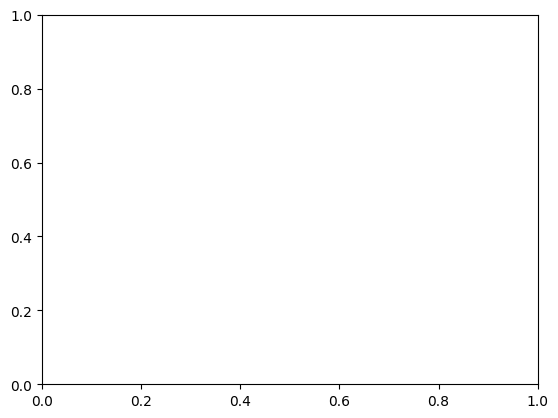

In [ ]:
plot_groups_disparity(demv.get_disparities()[0])
plt.title("DEMV with round_level=1")
plt.show()

In [ ]:
plot_groups_disparity(demv_fine.get_disparities()[0])
plt.title("DEMV with round_level=3")
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [81]:
demv.get_iters()

1184

After 1184 iterations, $W_{exp}/W_{obs}$ of all the groups converges to one. This means that all the groups are totally balanced.
